In [1]:
import pandas as pd
import joblib
import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
train_data = pd.read_csv("../data/model_train_data.csv")
test_data = pd.read_csv("../data/model_test_data.csv")

# Standardizing numerical features
# numerical_features = ["age",
#                       "fico_score",
#                       "income_level",
#                       "delinquency_status",
#                       "max_balance",
#                       "avg_balance_last_12months",
#                       "account_age_days",
#                      "earliest_credit_account_age_days",
#                       "days_recent_trade_activity",
#                       "new_accounts_opened_last_12months",
#                      "number_of_delinquent_accounts",
#                       "number_of_defaulted_accounts",
#                       "number_of_credit_applications",
#                       "debt_to_income_ratio"]

# scaler = MinMaxScaler()

# train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
# test_data[numerical_features] = scaler.transform(test_data[numerical_features])

# Seperate Features and Target
target = 'charge_off_status'

X_train = train_data.drop(columns=[target])  
y_train = train_data[target]  

X_test = test_data.drop(columns=[target])  
y_test = test_data[target]  


# One-hot encoding categorical features
categorical_features = ["occupation", "location"]

encoder = OneHotEncoder( handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

encoded_columns = encoder.get_feature_names_out(categorical_features)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_columns)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_columns)

X_train = X_train.drop(columns=categorical_features).reset_index(drop=True)
X_test = X_test.drop(columns=categorical_features).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

## Loading Model

In [3]:
log_reg = joblib.load('../models/xgboost_model.pkl')

## SHAP Values

In [4]:
shap.initjs()
explainer = shap.TreeExplainer(log_reg, X_train)
shap_values = explainer(X_test, check_additivity=False)

In [16]:
shap.summary_plot(shap_values, X_test,show=False)
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.close()

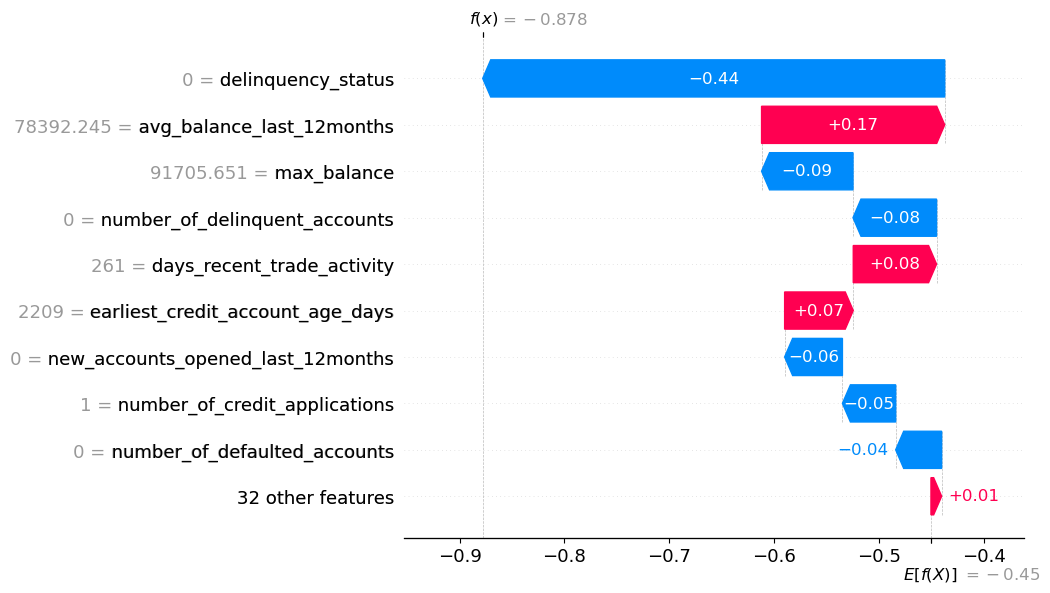

In [6]:
shap.plots.waterfall(shap_values[0])



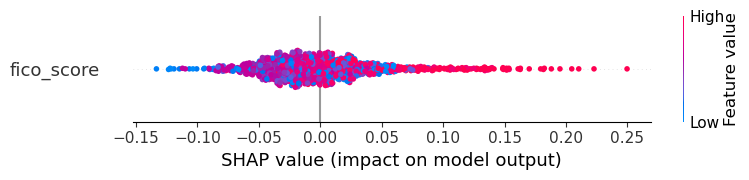

In [7]:

shap_values_for_delinquency = shap_values[:, X_test.columns.get_loc("fico_score")]


shap_values_for_delinquency_reshaped = shap_values_for_delinquency.values.reshape(-1, 1)


X_test_delinquency = X_test[['fico_score']]


shap.summary_plot(shap_values_for_delinquency_reshaped, X_test_delinquency)


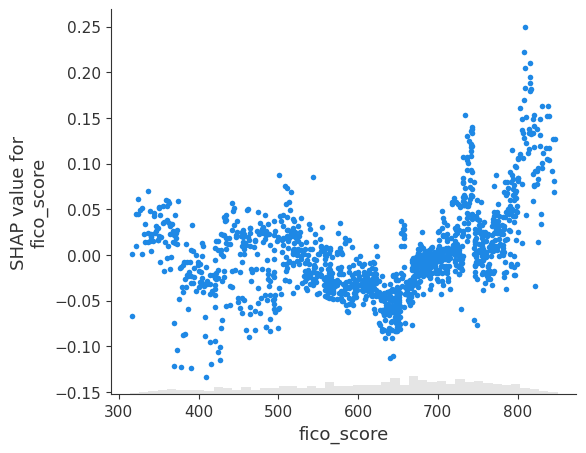

In [8]:
shap.plots.scatter(shap_values[:,"fico_score"] )

In [9]:
#shap.dependence_plot("delinquency_status", shap_values.values, X_test.values,interaction_index="fico_score",feature_names=X_test.columns,)

In [10]:
shap.force_plot(shap_values)

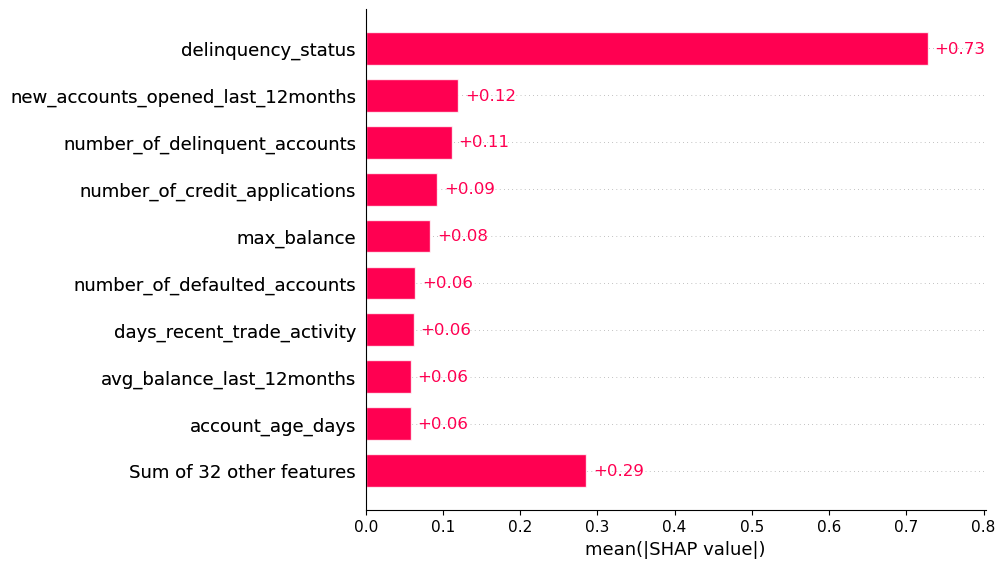

In [11]:
shap.plots.bar(shap_values)

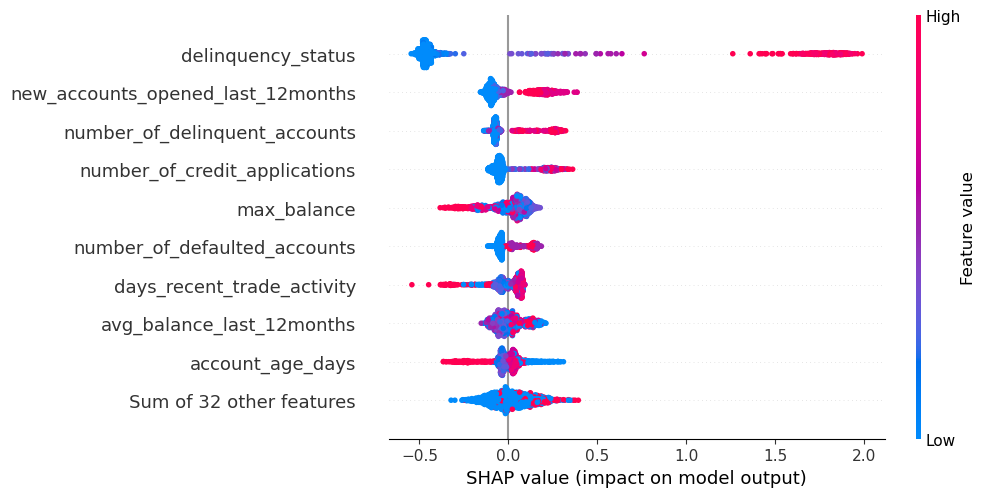

In [12]:
shap.plots.beeswarm(shap_values)

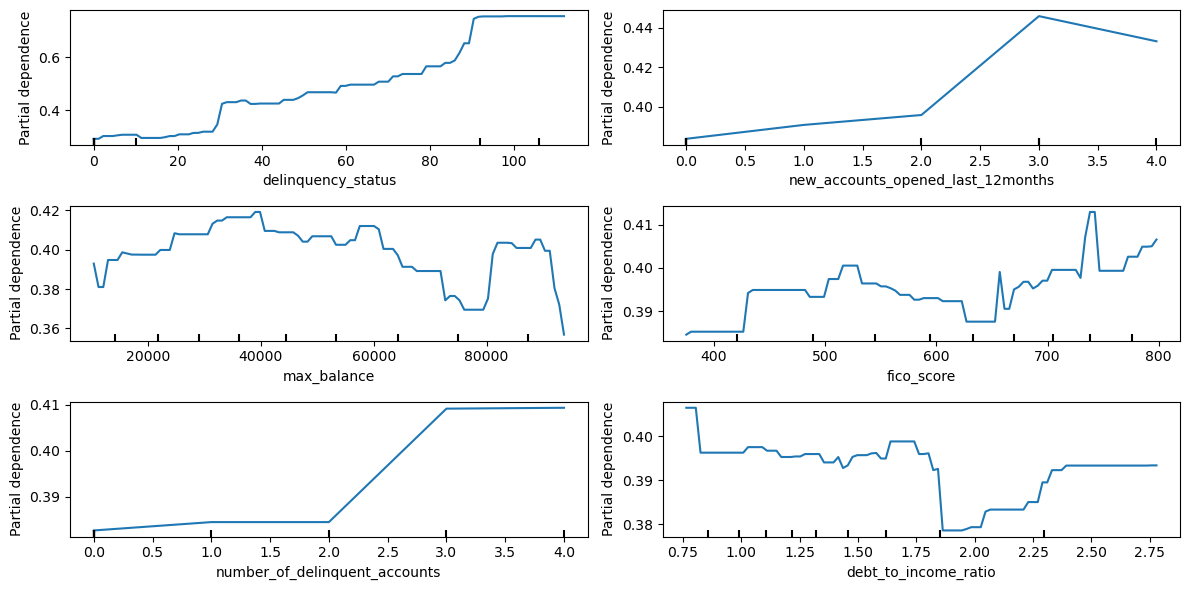

In [13]:
features = ['delinquency_status','new_accounts_opened_last_12months', 'max_balance', 'fico_score','number_of_delinquent_accounts','debt_to_income_ratio']


fig, ax = plt.subplots(nrows=(len(features) + 1) // 2, ncols=2, figsize=(12, 6))  # 2 plots per row
ax = ax.ravel()  # Flatten the axes array


for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(log_reg, X_train, features=[feature], ax=ax[i])
    
plt.tight_layout()
plt.show()